In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:

# --- Parameters ---
S_max = 150
K = 100
T = 1.0
r = 0.05
sigma0 = 0.2
alpha = 0.1
beta = 0.05

M = 300  # space steps
N = 2000  # time steps

dS = S_max / M
dt = T / N

S = np.linspace(0, S_max, M + 1)
tau = np.linspace(0, T, N + 1)

In [11]:
def local_vol(S, tau):
    return np.clip(sigma0 * (1 + alpha * np.sin(np.pi * S / K) + beta * tau), 0.05, 0.4)

# --- Boundary & Terminal Conditions ---
def boundary_conditions(tau):
    left = 0
    right = S_max - K * np.exp(-r * (T - tau))
    return left, right

In [12]:
V = np.maximum(S - K, 0)  # terminal condition
solution = np.zeros((N + 1, M + 1))
solution[-1] = V

In [13]:
# --- Tridiagonal Solver (Thomas Algorithm) ---
def solve_tridiagonal(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.copy, (a, b, c, d))
    
    for i in range(1, nf):
        mc = ac[i-1] / bc[i-1]
        bc[i] -= mc * cc[i-1]
        dc[i] -= mc * dc[i-1]

    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for i in reversed(range(nf - 1)):
        xc[i] = (dc[i] - cc[i] * xc[i+1]) / bc[i]

    return xc

In [14]:
# --- Crank–Nicolson Loop ---
for n in reversed(range(N)):
    t_n = tau[n]
    sigma = local_vol(S, t_n)

    a = np.zeros(M - 1)
    b = np.zeros(M - 1)
    c = np.zeros(M - 1)
    d = np.zeros(M - 1)

    for i in range(1, M):
        Si = S[i]
        sig = sigma[i]
        A = 0.25 * dt * (sig**2 * Si**2 / dS**2 - r * Si / dS)
        B = -0.5 * dt * (sig**2 * Si**2 / dS**2 + r)
        C = 0.25 * dt * (sig**2 * Si**2 / dS**2 + r * Si / dS)

        a[i - 1] = -A
        b[i - 1] = 1 - B
        c[i - 1] = -C

    for i in range(1, M):
        Si = S[i]
        sig = sigma[i]
        A = 0.25 * dt * (sig**2 * Si**2 / dS**2 - r * Si / dS)
        B = -0.5 * dt * (sig**2 * Si**2 / dS**2 + r)
        C = 0.25 * dt * (sig**2 * Si**2 / dS**2 + r * Si / dS)

        d[i - 1] = A * solution[n+1, i-1] + (1 + B) * solution[n+1, i] + C * solution[n+1, i+1]

    left, right = boundary_conditions(t_n)
    d[0] -= a[0] * left
    d[-1] -= c[-1] * right

    V_inner = solve_tridiagonal(a, b, c, d)

    solution[n, 0] = left
    solution[n, M] = right
    solution[n, 1:M] = V_inner

In [15]:
# --- Delta Surface ---
from scipy.interpolate import UnivariateSpline

delta = np.zeros_like(solution)

for n in range(N + 1):
    spline = UnivariateSpline(S, solution[n], s=1e-3)
    delta[n] = spline.derivative(n=1)(S)


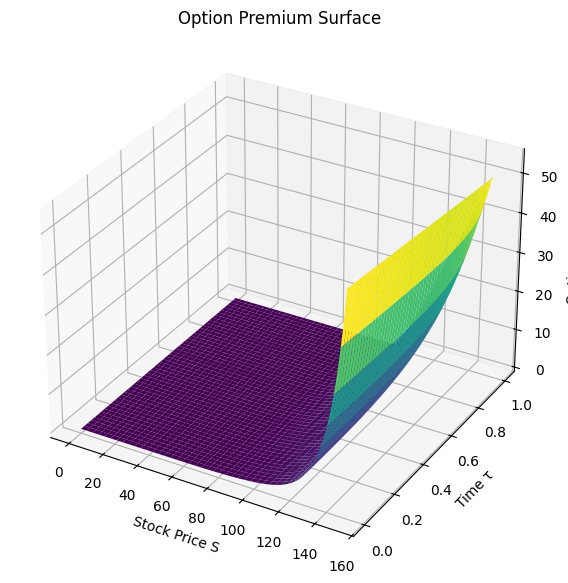

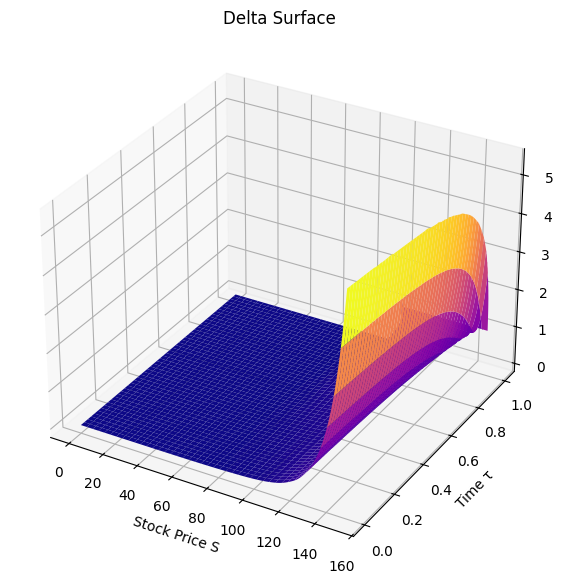

In [16]:
# --- Visualization ---
T_grid, S_grid = np.meshgrid(tau, S)

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(S_grid, T_grid, solution.T, cmap='viridis')
ax1.set_title("Option Premium Surface")
ax1.set_xlabel("Stock Price S")
ax1.set_ylabel("Time τ")
ax1.set_zlabel("Option Price V")

fig2 = plt.figure(figsize=(10, 7))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(S_grid, T_grid, delta.T, cmap='plasma')
ax2.set_title("Delta Surface")
ax2.set_xlabel("Stock Price S")
ax2.set_ylabel("Time τ")
ax2.set_zlabel("Delta")

plt.show()
